In [1]:
import pandas as pd
import numpy as np
import PIL
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

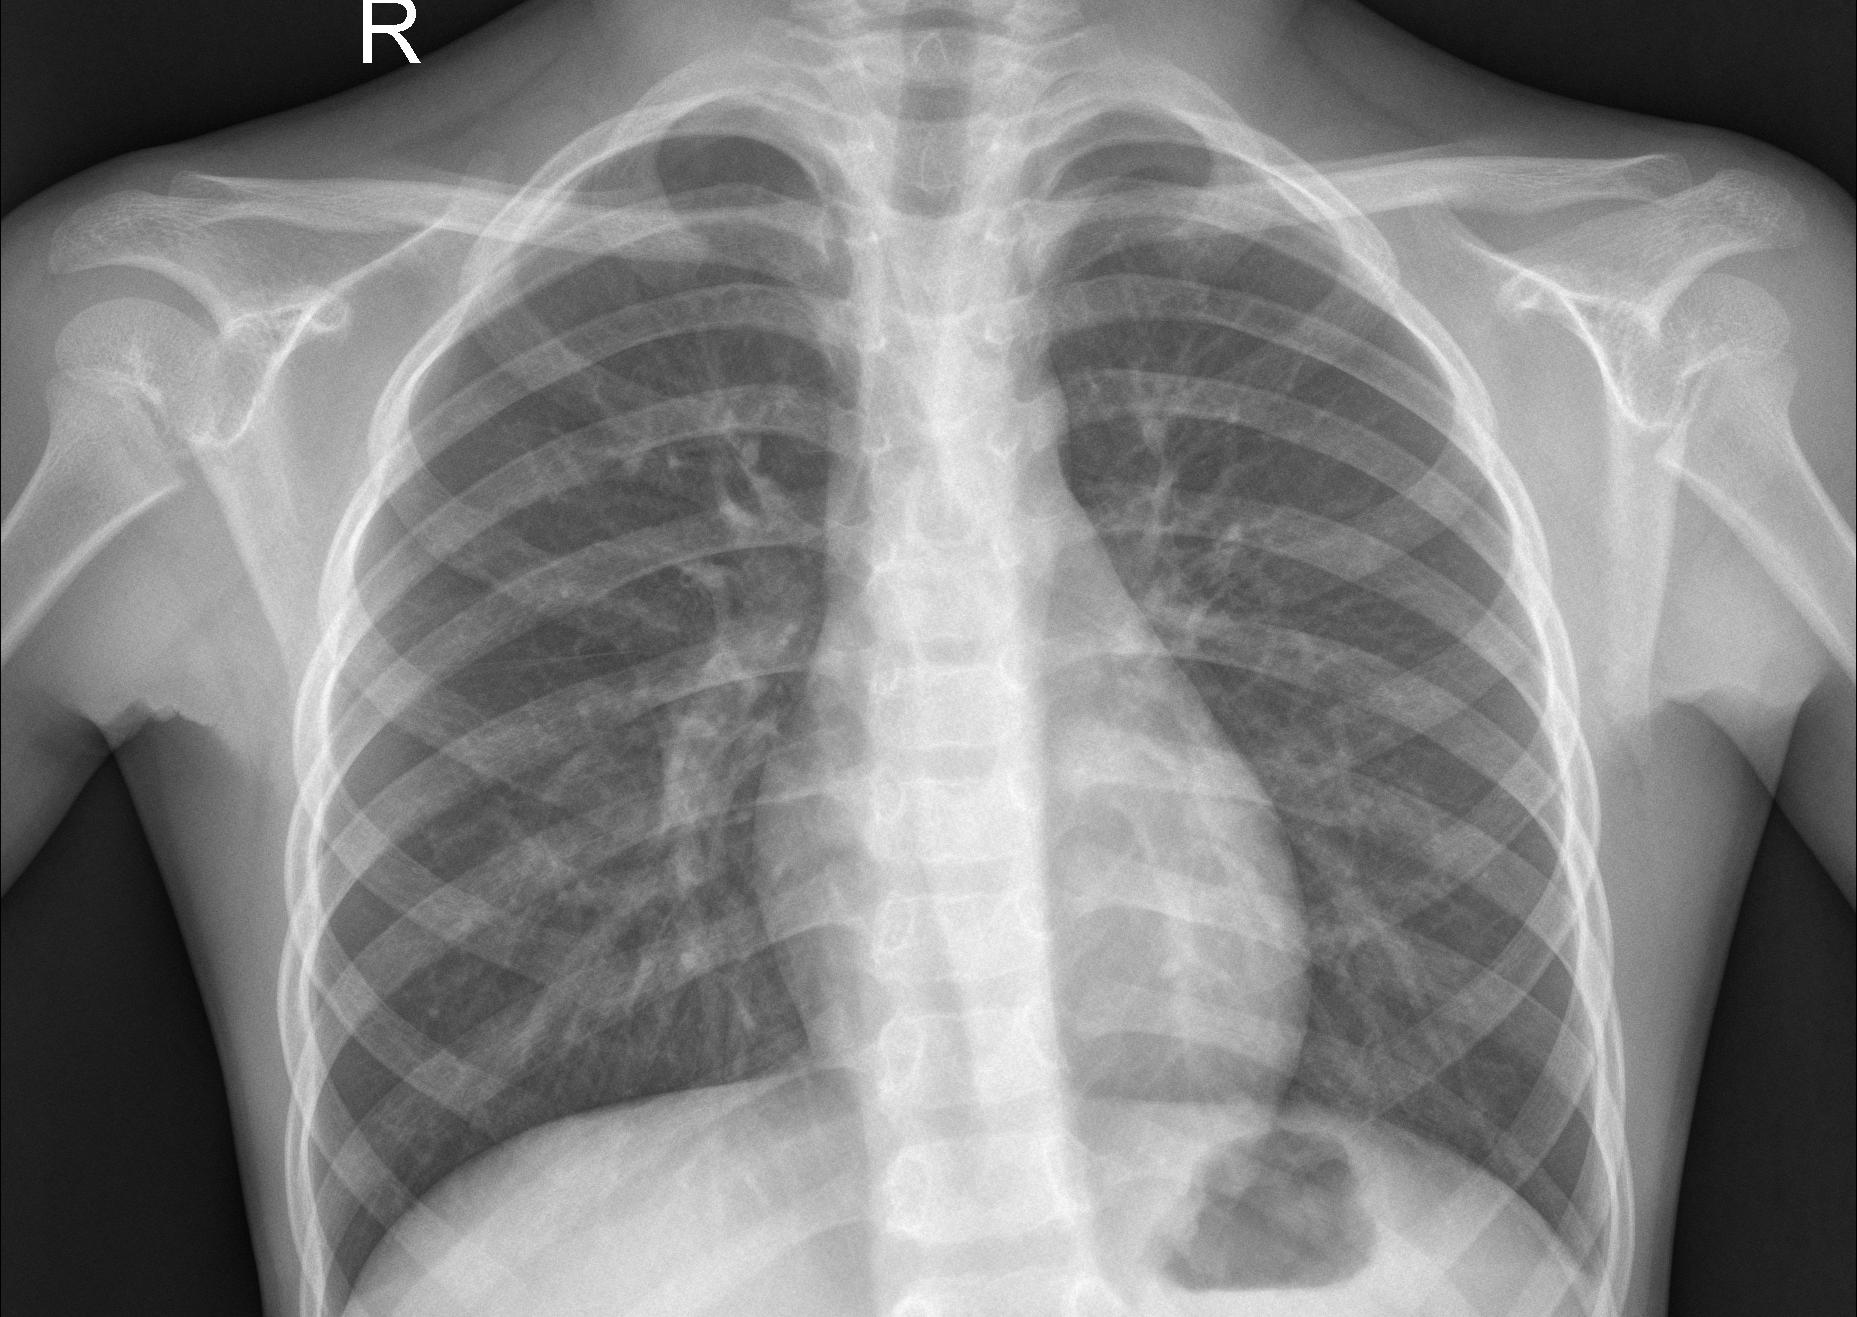

In [4]:
image = PIL.Image.open('../kaggle/chest_xray/test/NORMAL/IM-0001-0001.jpeg')

image

In [ ]:
image = PIL.Image.open('/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg')

image

In [ ]:
train = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
test = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'
validation = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'

In [ ]:
training_generator = ImageDataGenerator(rescale=1/255)

data_train = training_generator.flow_from_directory(train, target_size=(256,256))

In [ ]:
validation_generator = ImageDataGenerator(rescale=1/255)

data_valid = validation_generator.flow_from_directory(validation, target_size=(256,256))

In [ ]:
test_generator = ImageDataGenerator(rescale=1/255)

data_test = test_generator.flow_from_directory(test, target_size=(256,256))

## CNN

In [ ]:
from tensorflow.keras import regularizers

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_regularizer=regularizers.l2(0.001),input_shape=(256,256,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    #tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    #tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
    #tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(2,activation='sigmoid')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['acc','f1_score'])

In [ ]:
model.summary()

In [ ]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=1)
#checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

In [ ]:
# history = model.fit(data_train,epochs=100,validation_data=data_valid)
history = model.fit(
    data_train,
#     steps_per_epoch=len(data_train),
    epochs=20,
    validation_data=data_valid,
#     validation_steps=len(data_valid)
#     callbacks=[checkpoint]
    callbacks=[callbacks]
)

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy'),
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss'),
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title("Model F1 Score")
plt.ylabel("F1 Score")
plt.xlabel("Epoch")
plt.legend(['train','val'],loc="upper left")
plt.show()

In [ ]:
results = model.evaluate(data_test,verbose=0)
print(results)

In [ ]:
print("    Test Loss : {:.5f}".format(results[0]))
print("Test Accuracy : {:.2f}".format(results[1]*100))

In [ ]:
# pred = model.predict(data_test)
# pred = np.argmax(pred,axis=1)

# labels = (data_test.class_indices)
# labels = dict((v,k) for k,v in labels.items())
# pred - [labels[k] for k in pred]

pred = model.predict(data_test)
pred = np.argmax(pred, axis=1)

labels = data_test.class_indices
labels = {v: k for k, v in labels.items()}

# Corrected line: Assign the modified values to 'pred'
pred = [labels[k] for k in pred]

In [ ]:
print(pred)

In [ ]:
from sklearn.metrics import classification_report

y_test = list(data_test.labels)
# print(y_test)
# Example mapping from class names to numeric labels
class_to_label = {0 :"NORMAL", 1 :"PNEUMONIA"}

# Convert true labels (strings) to numeric labels
numeric_true_labels = [class_to_label.get(label, -1) for label in y_test]

# Now use numeric_true_labels in the classification report
print(classification_report(numeric_true_labels, pred))




In [ ]:
batch_images, batch_labels = next(data_test)

fig,axes = plt.subplots(nrows=5,ncols=2,figsize=(12,8),subplot_kw={'xticks':[],'yticks':[]})

for i, ax in enumerate(axes.flat):
    ax.imshow(batch_images[i])
    ax.set_title(f"True:{data_test.classes[i]}\n Predicted:{pred[i]}")

plt.tight_layout()
plt.show()
                 

In [ ]:
my_model = model.save('pneumonia_detection.h5')